# **3. Text Preprocessing**
#### Juan Julián Cea Morán

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Electronic-Arts-Logo.svg/1200px-Electronic-Arts-Logo.svg.png" width=100px>

---
As sawn in the EDA section, we are working with text in 3 possible languages: english, spanish and french. We have no indication that the final system can work with more languages, so we will only focus on those three.

This means that we are working with a mulitlingual dataset. To solve this task it will be necessary to apply textual pre-processing adapted to each of the different languages present in the dataset. 

There are several ways to achieve this requierement: for example, it could be done by building regular expressions so all exceptions founded in texts could be captured. Another option would be breaking the data apart by language and use specifict tools for each language.

In this case we are using the second approach, so we have to identify th language of each text and then apply specifict transformation functions.

---

The first step is to take pandas dataframe from EDA section and use the 'text' column to preprocess each sample.

In [21]:
import pickle
import pandas as pd

docs_df = pickle.load(open("../data/docs_df.pkl", 'rb'))

In [22]:
docs_df.head()

,Name,Text,Lang,Category
0,apr-book-0-en.txt,"i read this book because in my town, everyone ...",en,APR
1,apr-book-1-en.txt,recipes appreciated by the family (small and l...,en,APR
2,apr-book-10-en.txt,i say no to ease ..... and not to the author w...,en,APR
3,apr-book-100-en.txt,milady has found a good vein: anita blake. bas...,en,APR
4,apr-book-1000-en.txt,"460 bc, somewhere in greece: ""gentlemen, i dec...",en,APR


Now we have to work with 'Text' column. Then, dump the result as a new column in the dataset.

In [23]:
lang_df = docs_df[['Text', 'Lang']]
lang_df.head()

,Text,Lang
0,"i read this book because in my town, everyone ...",en
1,recipes appreciated by the family (small and l...,en
2,i say no to ease ..... and not to the author w...,en
3,milady has found a good vein: anita blake. bas...,en
4,"460 bc, somewhere in greece: ""gentlemen, i dec...",en


---

## Language identification
There are some python libraries that address this issue. For example: 
* LangID: Developped by Lui Marco, is a standalone Language Identification (LangID) tool bassed on previous researchs by the authors. https://github.com/saffsd/langid.py
* langdetect: Port of Nakatani Shuyo's language-detection library (version from 03/03/2014) to Python. https://github.com/Mimino666/langdetect
* TextBlob: A popular Text Processing package for Python. It includes a module for language detection based on a Google API. Requires Internet conection. https://textblob.readthedocs.io/en/dev/

Let's compare them!

In [78]:
# Let's take text in the 3 languages
en = lang_df.loc[(lang_df['Lang'] == 'en')][0:100]
es = lang_df.loc[(lang_df['Lang'] == 'es')][0:100]
fr = lang_df.loc[(lang_df['Lang'] == 'fr')][0:100]

sample_texts = pd.concat([en, es, fr])

In [123]:
import langid

_langid = [l [0] for l in sample_texts['Text'].apply(langid.classify)]

In [128]:
from langdetect import detect

_langdetect = [l for l in sample_texts['Text'].apply(langdetect.detect)]

In [132]:
from textblob import TextBlob

_textblob = [TextBlob(l).detect_language() for l in sample_texts['Text']]

In [134]:
langid_error =  0
langdetect_error = 0
textblob_error = 0

sample_texts_lang = [s for s in sample_texts['Lang']]

for i in range(0, len(sample_texts_lang)):
    if _langid[i] != sample_texts_lang[i]:
        langid_error += 1
    if _langdetect[i] != sample_texts_lang[i]:
        langdetect_error += 1
    if _textblob[i] != sample_texts_lang[i]:
        textblob_error += 1
        
print('LangID Error:', langid_error)
print('LangDetect Error:', langdetect_error)
print('TextBlob Error:', textblob_error)

LangID Error: 0
LangDetect Error: 1
TextBlob Error: 0


A we can see, we get similar results using any of this packages. We are going to use the first one, langID. Let's try it with the whole dataset.

In [141]:
full_langid = [l [0] for l in lang_df['Text'].apply(langid.classify)]

In [144]:
error = 0

full_langs = [s for s in lang_df['Lang']]

for i in range(0, len(full_langs)):
    if full_langid[i] != full_langs[i]:
        error += 1

print(error)

1656


**Update**: As it can be seen, this approach can perform well with a little subsample of the original dataset, but it return 1656 miss classifications when using the entire dataset. Due to that, we are going to use a preprocessing function capable of perform well in every language.

---
## Cleaning and tokenize
This process is crucial, as it will lay the foundation for all the other steps in the project. To do this, the text will have to be normalized, cleaned and tokenised.

This involves performing a set of transformations on each example. Firstly, a unidecode will be applied in order to remove the accents. Then, the text will be converted to lowercase. At this point, different regular expressions will be applied to filter out urls, html information, numbers and finally only keep alphabetic information. The next step will be to divide the text in tokens separating it by spaces and discarding stopwords (very common words that do not provide semantic information for this task). The next function will perform these steps.

In [31]:
import re
import string
import unidecode
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# nltk.download('punkt')
# nltk.download('stopwords')

stopwords = stopwords.words("french") + stopwords.words("english") + stopwords.words("spanish")

def preprocess(text):
    text = unidecode.unidecode(text.strip().lower())
    
    url_regex = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = url_regex.sub(' ', text)
    
    html_pattern = re.compile('<.?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    text =  html_pattern.sub(' ', text)
    
    chars_regex = re.compile('[^a-zA-Z0-9 -]')
    text = chars_regex.sub(' ', text)

    number_regex = re.compile('[\d]+')
    text = number_regex.sub(' ', text)
    
    text = ' '.join(text.split('\''))
    
    text = word_tokenize(text)
    
    text = [word for word in text if word not in stopwords and len(word)>2]
    
    return text

In [25]:
%%time
import pandas as pd

preprocessed = list()
for text in docs_df['Text']:
    preprocessed.append(preprocess(text))

docs_df.insert(2, 'Preprocessed', preprocessed)

Wall time: 4min 44s


In [26]:
docs_df.head()

,Name,Text,Preprocessed,Lang,Category
0,apr-book-0-en.txt,"i read this book because in my town, everyone ...","[read, book, town, everyone, uses, order, phar...",en,APR
1,apr-book-1-en.txt,recipes appreciated by the family (small and l...,"[recipes, appreciated, family, small, large, r...",en,APR
2,apr-book-10-en.txt,i say no to ease ..... and not to the author w...,"[say, ease, author, even, made, effort, meet, ...",en,APR
3,apr-book-100-en.txt,milady has found a good vein: anita blake. bas...,"[milady, found, good, vein, anita, blake, base...",en,APR
4,apr-book-1000-en.txt,"460 bc, somewhere in greece: ""gentlemen, i dec...","[somewhere, greece, gentlemen, decided, visit,...",en,APR


---
## Explore results
Now that we have our texts preprocessed, it's time to explore the data and see the preprocessing result. This process is important because we want our model to perform well by only "paying attention" to relevant terms in the corpus.

Let's generate some wordclouds for each category and language.

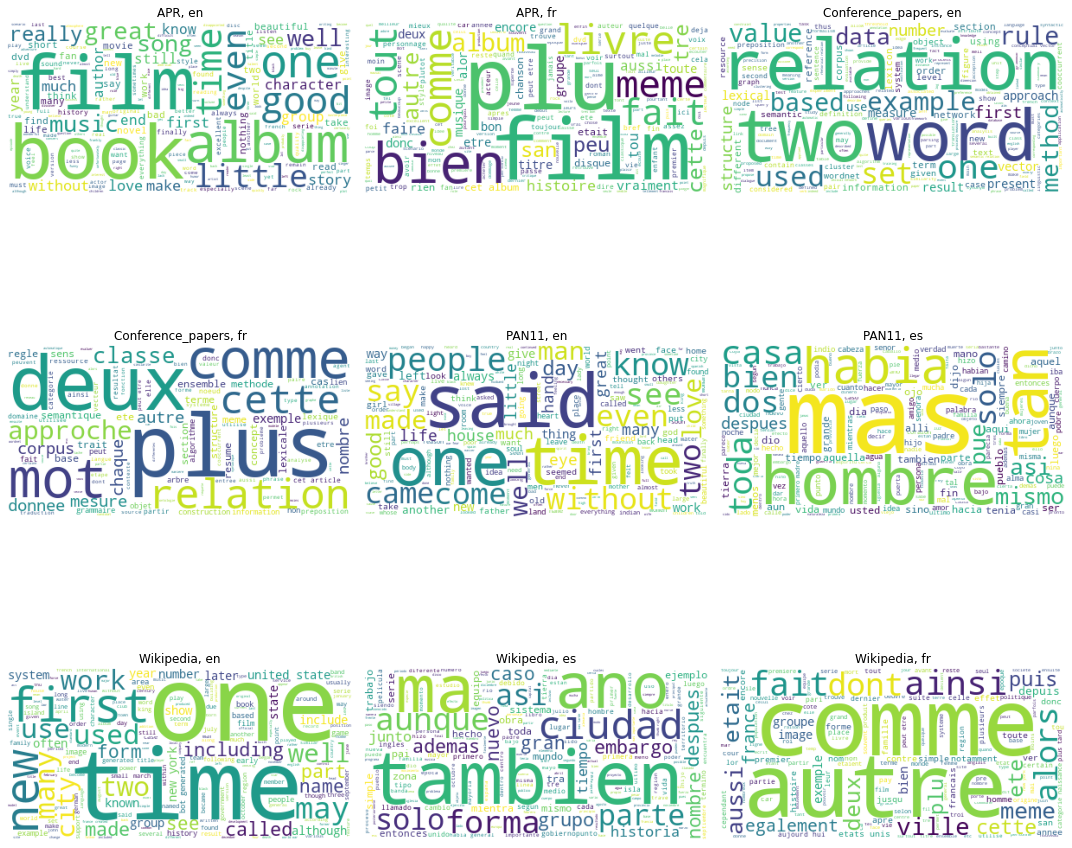

In [27]:
from wordcloud import WordCloud

import matplotlib.pyplot as plt
%matplotlib inline

idx = 0

fig = plt.figure(figsize=(15, 15))

for cat in docs_df['Category'].unique():
    aux = docs_df[docs_df['Category'] == cat]
    for lang in aux['Lang'].unique():
        texts = aux[aux['Lang'] == lang]['Preprocessed'].apply(' '.join).tolist()
        
        wordcloud = WordCloud(background_color="white").generate(' '.join(texts))
        
        idx += 1
        
        plt.subplot(3, 3, idx)
        plt.title(f"{cat}, {lang}")
        plt.imshow(wordcloud)
        plt.axis('off')

fig.tight_layout()

As it can be seen, in this cases, the mos frequent terms in each wordcloud are not stopwords. This means that now we are working with semantically relevant terms.

Now, lets perform tf-idf to check the top relevant words from each one of those partitions.

**Note:** tf-idf model will be explained in deep in the next notebook.

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer 
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')

top_n = 20

idx = 0

fig = plt.figure(figsize=(15, 15))

for cat in docs_df['Category'].unique():
    aux = docs_df[docs_df['Category'] == cat]
    for lang in aux['Lang'].unique():
        texts = aux[aux['Lang'] == lang]['Preprocessed'].tolist()

        tfidf_vectorizer = TfidfVectorizer(use_idf=True, min_df=12)
        tfidf = tfidf_vectorizer.fit_transform([' '.join(text) for text in texts])
        indices = np.argsort(tfidf_vectorizer.idf_)[::-1]
        features = tfidf_vectorizer.get_feature_names()
        top_features = [features[i] for i in indices[:top_n]]
        
        idx += 1
        
        print(top_features, tfidf_vectorizer.idf_[::-1])
        df = pd.DataFrame(index=top_features, columns=['score'])
        df['score'] = [tfidf_vectorizer.idf_[i] for i in indices[:top_n]]
        
        print(df.head())
        break
        
        print(np.argsort(tfidf_vectorizer.idf_)[::-1])
        sns.barplot(data=df)

        plt.subplot(3, 3, idx)
        plt.title(f"{cat}, {lang}")
        plt.show(sns)
        plt.axis('off')

fig.tight_layout()

['lara', 'helped', 'clip', 'clever', 'scary', 'church', 'enthusiasm', 'section', 'choices', 'check', 'charles', 'environment', 'sensual', 'rotten', 'eponymous', 'sequel', 'faults', 'serve', 'channel', 'setting'] [5.64580393 5.67565689 6.60721509 ... 6.60721509 4.84143111 6.53310712]
           score
lara    6.607215
helped  6.607215
clip    6.607215
clever  6.607215
scary   6.607215
['corresponding', 'value', 'summary', 'finally', 'subcategorization', 'three', 'meaning', 'time', 'definition', 'similar', 'shows', 'base', 'sentence', 'task', 'define', 'correspond', 'verbs', 'properties', 'propose', 'positive'] [3.85263143 3.43141796 3.56494936 3.28623595 4.25809654 3.52985804
 3.90142159 4.33220451 4.00678211 3.601317   3.90142159 3.67827804
 4.33220451 3.49595649 4.12456515 2.81961642 3.46316666 4.06394052
 4.25809654 2.64865863 3.90142159 3.90142159 4.12456515 4.33220451
 3.43141796 4.33220451 4.00678211 4.00678211 3.67827804 4.33220451
 3.80611141 3.76165965 4.12456515 4.18910367 4.33

<Figure size 1080x1080 with 0 Axes>


---
Now let's export data so I can work with it in the next sections.

In [71]:
preproc_df = docs_df.drop(columns=["Name", "Text"])

In [72]:
import pickle

output = open('../data/preproc_df.pkl', 'wb')
pickle.dump (preproc_df, output)
output.close()

---

#### **Preprocessing Conclusions**

In this section, I have prepared the data to be used by our next models. I have normalize the data by cleaning undesired characters, numbers, etc. I have also tokenized the text so it could ve transformed into numbers in the next section. All this process has been done iteratively, so the final results are the best version I have generated.

In **future iterations of this work**, it could be interesting to test some NLP features commonly used in preprocessing like n-grams, stemming, lemmatization, etc. It would be interesting to improve the language detection section, since most part of this features are language dependent.

---